In [1]:
from scipy import optimize as opt
from scipy.optimize import Bounds

# Create a graph for the problem its is also adviseable to instantiate the weight of the graphs else it 
# be defaulted to 1
import networkx as nx 
import numpy as np
import matplotlib.pyplot as plt 
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter

n     = 2
V     = np.arange(0,n,1)
E     =[(0,1,10.0)] 

G     = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

nx.draw(G,with_labels=1, pos=nx.spring_layout(G), node_color='w', edge_color='g')

/home/anand/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


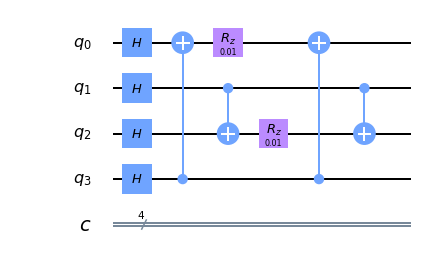

In [2]:
from qiskit import *

qc = QuantumCircuit(4,4)
qc.h(0)
qc.h(1)
qc.h(2)
qc.h(3)

qc.cx(3,0)
qc.rz(0.01, 0)
qc.cx(3,0)

qc.cx(1,2)
qc.rz(0.01, 2)
qc.cx(1,2)

qc.draw(output='mpl')

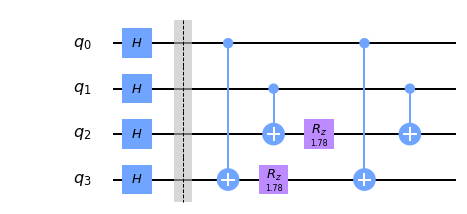

In [3]:
import os 
os.path.sys.path.append('../hamiltonian_engine/')
from hamiltonian import phase_hamiltonian as phs_ham

obj_function = 'x_1 + x_2 - 2*x_1*x_2'
variables = ['x_1','x_2']

phase_h = phs_ham(obj_function,variables)
phase_h.Hamify()
phase_h.get_pHamil()

cir = phase_h.perDitMap(1.78218631, 1, 2, G, sub_expr={'i':'i+1'}, initial_Hadamard=True)
cir.draw(output='mpl')

##### SWAP GATE TEST

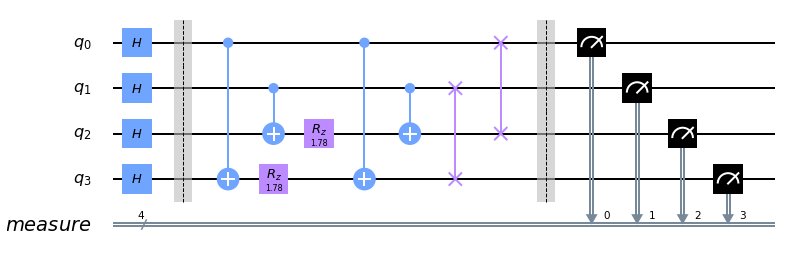

In [4]:
cir.swap(1,3)
cir.swap(0,2)

cir.measure_all()

cir.draw(output='mpl')

backend setup: Complete running circuit


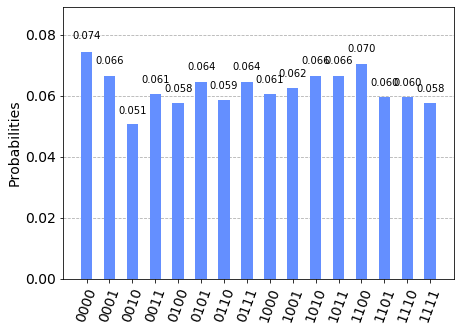

In [5]:
backend = Aer.get_backend("qasm_simulator")
print('backend setup: Complete running circuit')

simulate     = execute(cir, backend=backend, shots=1024)
results = simulate.result()
counts = results.get_counts()
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [6]:
lis = [0,1,2,3]
def generate_quantumCircuit(graph:nx.Graph, hyperparams:list):
        if graph == None:
            raise ValueError('Missing Argument: {} for "graph:nx.Graph"'.format(graph))
        else:
            cir = phase_h.perDitMap(hyperparams[0], 1, 2, G, sub_expr={'i':'i+1'}, initial_Hadamard=True) + local_4XY(lis,2*hyperparams[1],4,'XXXX') 
            cir += local_4XY(lis,2*hyperparams[1],4,'YYXX') + local_4XY(lis,2*hyperparams[1],4,'XYXY') + local_4XY(lis,2*hyperparams[1],4,'YXYX') + local_4XY(lis,2*hyperparams[1],4,'XYYX')
            cir += local_4XY(lis,2*hyperparams[1],4,'YXXY') + local_4XY(lis,2*hyperparams[1],4,'XXYY') + local_4XY(lis,2*hyperparams[1],4,'YYYY')

            cir.measure_all()

            return cir

In [7]:
def MAX_CUT( hyperparameters:list):
        cir = generate_quantumCircuit(G, hyperparameters)

        backend = Aer.get_backend("qasm_simulator")
        simulate     = execute(cir, backend=backend, shots=1024)
        results = simulate.result()
        
        counts = results.get_counts()
        exp = 0
        for c in counts:
            exp += (counts[c]/1024)*((int(c[0]) + int(c[3])) + (int(c[1]) + int(c[2]))) 

        return -1 * exp

In [8]:
def run_QAOA(init_hyperparams:list, method:str):
        #define the bounds for the hyperparameters
        bounds = [[0, 2*np.pi], [0, np.pi]]
        cons = []
        for factor in range(len(bounds)):
            lower, upper = bounds[factor]
            l = {'type': 'ineq',
                'fun': lambda x, lb=lower, i=factor: x[i] - lb}
            u = {'type': 'ineq',
                'fun': lambda x, ub=upper, i=factor: ub - x[i]}
            cons.append(l)
            cons.append(u)
        
        res = opt.minimize(MAX_CUT, init_hyperparams,constraints=cons, tol= 1e-3, method=method)

        print(res)

        return res.x        

#### XY mixers

In [9]:
import numpy as np
# 4-local mixer hamiltonian 
def local_4XY(qubit_list:list, beta,num_qubit,typ="XXXX"):
    cir = QuantumCircuit(num_qubit)
    i = 0
    for q in qubit_list:
        if typ[i] =='X':
            cir.h(q)
        else:
            cir.rx(np.pi/2,q)
        i += 1
            
    for i in range(len(qubit_list)):
        if i + 1 <= len(qubit_list) - 1:
            cir.cx(qubit_list[i],qubit_list[i+1])
    
    cir.rz(beta, qubit_list[-1])
        
    for i in range(len(qubit_list)-1, 0, -1):
        cir.cx(qubit_list[i-1], qubit_list[i])
        
        
    i = 0
    for q in qubit_list:
        if typ[i] =='X':
            cir.h(q)
        else:
            cir.rx(np.pi/2,q)
        i += 1
    
    
    return cir
        

In [10]:
hyperparams = [4.60950764, 2.990971 ]

x = run_QAOA(init_hyperparams=hyperparams,method='COBYLA')

     fun: -2.0087890625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 24
  status: 1
 success: True
       x: array([4.61810899, 3.14159265])


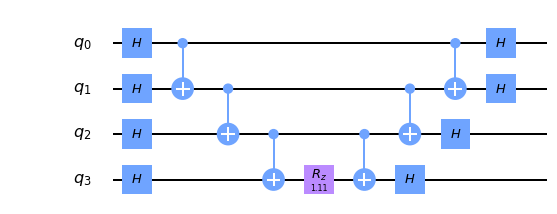

In [11]:
cir = local_4XY([0,1,2,3],1.1111 ,4, typ='XXXX')
cir.draw(output='mpl')

In [12]:
lis = [0,1,2,3]

cir = phase_h.perDitMap(x[0], 1, 2, G, sub_expr={'i':'i+1'}, initial_Hadamard=True) + local_4XY(lis,2*x[1],4,'XXXX') 

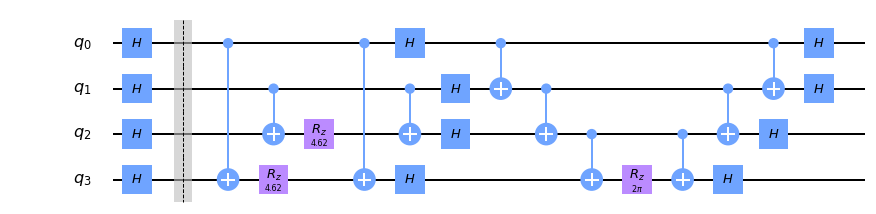

In [13]:
cir.draw(output='mpl')

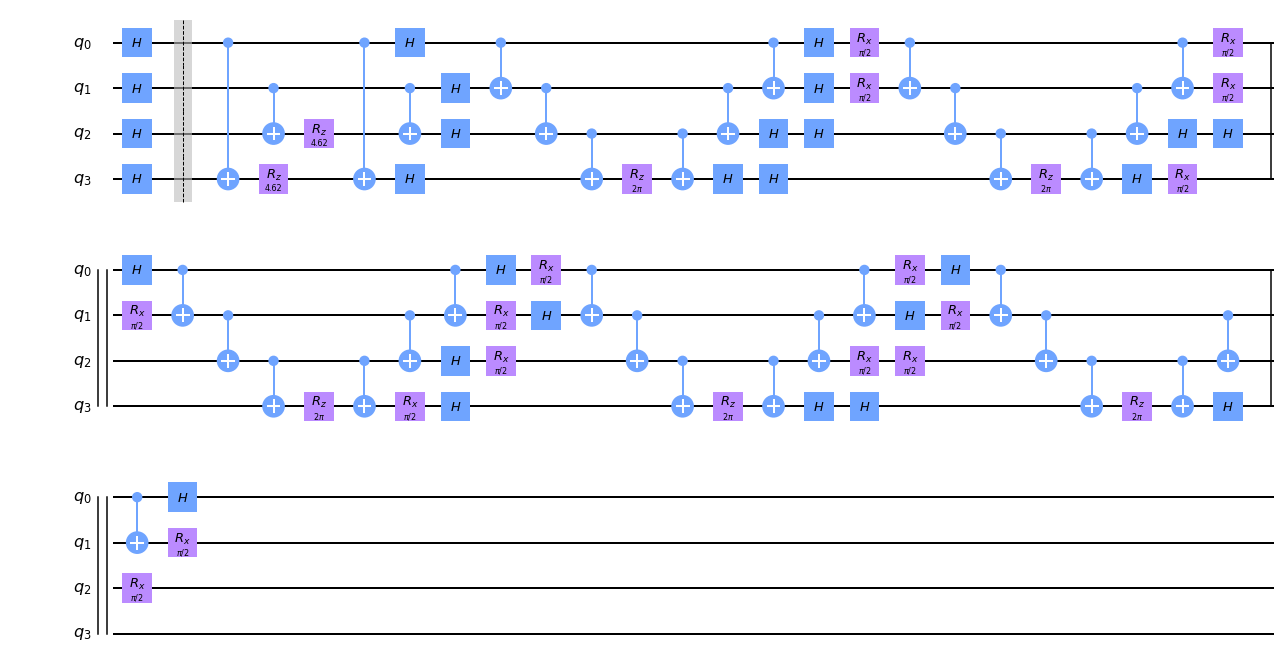

In [14]:
cir += local_4XY(lis,2*x[1],4,'YYXX') + local_4XY(lis,2*x[1],4,'XYXY') + local_4XY(lis,2*x[1],4,'YXYX') + local_4XY(lis,2*x[1],4,'XYYX')
cir.draw(output='mpl')

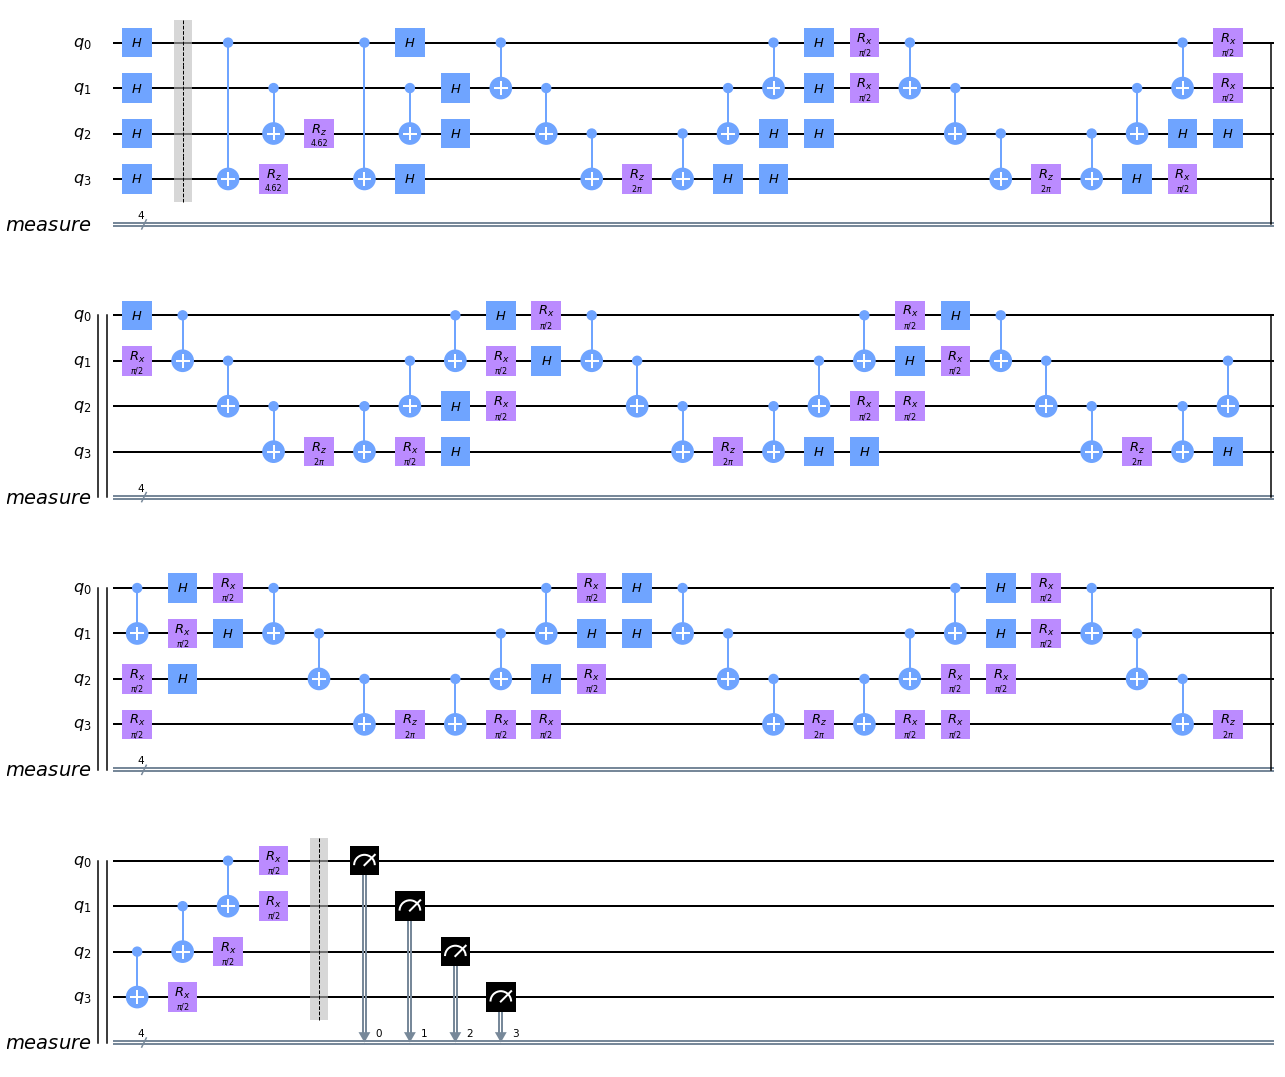

In [15]:
cir += local_4XY(lis,2*x[1],4,'YXXY') + local_4XY(lis,2*x[1],4,'XXYY') + local_4XY(lis,2*x[1],4,'YYYY')
cir.measure_all()
cir.draw(output='mpl')

backend setup: Complete running circuit


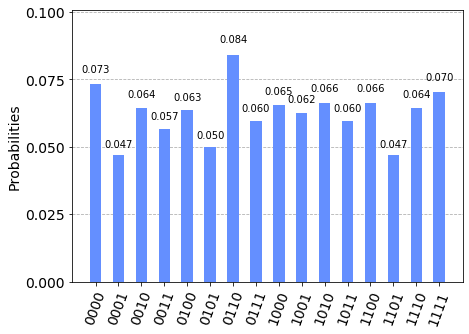

In [16]:
backend = Aer.get_backend("qasm_simulator")
print('backend setup: Complete running circuit')

simulate     = execute(cir, backend=backend, shots=1024)
results = simulate.result()
counts = results.get_counts()
from qiskit.visualization import plot_histogram
plot_histogram(counts)